# Image Super Resolution using Deep Learning

Author: Dominik Chodounský, Faculty of Information Technology, CTU in Prague

## Imports

In [17]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, BatchNormalization, Activation, MaxPooling2D, Dropout, concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError, mean_squared_error
from tensorflow.keras.optimizers import Adam, RMSprop, Nadam
from tensorflow.keras.applications import VGG19
from tensorflow.keras import callbacks
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, HTML, display
import cv2
import pandas as pd
import imageio as iio
from tqdm import tqdm
import os
import random
import warnings
import pickle

warnings.filterwarnings("ignore")

In [18]:
from utils import *
from unet import *
from srgan import *

## Data setup

In [19]:
img_size = 64
target_size = 128
batch_size = 4
rand_seed = 42
train_dir = os.path.join('../', 'data', 'vimeo', 'train_paths.txt')
test_dir = os.path.join('../', 'data', 'vimeo', 'test_paths.txt')
save_dir = os.path.join('../', 'models')

np.random.seed(rand_seed)
tf.random.set_seed(rand_seed)
random.seed(rand_seed)
os.environ['PYTHONHASHSEED'] = str(rand_seed)

warnings.filterwarnings("ignore")

In [20]:
train_list = []
with open(train_dir, 'r') as f:
    for line in f.readlines():
        train_list.append(line)
        
test_list = []
with open(test_dir, 'r') as f:
    for line in f.readlines():
        test_list.append(line)

In [21]:
print('Training:', len(train_list), 'septuplet sequences  |  Test images:', len(test_list), 'septuplet seqeunces')

Training: 7041 septuplet sequences  |  Test images: 783 septuplet seqeunces


In [22]:
# Perceptual loss function 

vgg = VGG19(include_top=False, weights='imagenet', input_shape=(None,None,3))
perception = Model(inputs=vgg.input, outputs=vgg.get_layer('block3_conv3').output, name='VGG_loss')
for layer in perception.layers: 
    layer.trainable = False 

def perceptual_loss(y_true, y_pred):
    yt_features = perception(y_true)
    yp_features = perception(y_pred)
    loss = mean_squared_error(yt_features, yp_features)
    return loss

## SR-U-Net

In [7]:
unet = unet(img_size)
unet.summary()

Model: "SR-U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 64)   1792        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 64, 64, 64)   0           batch_normalization[0][0]        
___________________________________________________________________________________________

### Training

In [8]:
model_save = os.path.join(save_dir, 'vimeo_SRUNET_perceptual_64_to_128' + '.h5')

# callback for early stopping regularization
early_stopping = callbacks.EarlyStopping(
    monitor='loss',
    min_delta=0,
    patience=5,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

# callback for continuous checkpointing of best model configuration
checkpointing = callbacks.ModelCheckpoint(
    filepath=model_save,
    monitor='loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

In [9]:
train_gen = generator_vimeo(train_list, img_size, target_size, batch_size)

In [11]:
unet.compile(optimizer=Adam(learning_rate=0.001),
              loss=perceptual_loss, #MeanSquaredError(),
              metrics=[psnr, ssim, MeanSquaredError()])

history = unet.fit(x=train_gen,
                    steps_per_epoch=np.ceil(float(len(train_list)) / float(batch_size)),
                    epochs=30,
                    verbose=1,
                    callbacks=[early_stopping, checkpointing])

Epoch 1/30
1761/1761 [==============================] - ETA: 0s - loss: 2.1732 - psnr: 12.0930 - ssim: 0.4451 - mean_squared_error: 0.1307
Epoch 00001: loss improved from 4.67629 to 2.17319, saving model to ../models\vimeo_SRUNET_perceptual_64_to_128.h5
1761/1761 [==============================] - 475s 270ms/step - loss: 2.1732 - psnr: 12.0930 - ssim: 0.4451 - mean_squared_error: 0.1307
Epoch 2/30
1761/1761 [==============================] - ETA: 0s - loss: 1.8104 - psnr: 13.6671 - ssim: 0.4788 - mean_squared_error: 0.1096
Epoch 00002: loss improved from 2.17319 to 1.81038, saving model to ../models\vimeo_SRUNET_perceptual_64_to_128.h5
1761/1761 [==============================] - 480s 273ms/step - loss: 1.8104 - psnr: 13.6671 - ssim: 0.4788 - mean_squared_error: 0.1096
Epoch 3/30
1761/1761 [==============================] - ETA: 0s - loss: 1.5598 - psnr: 14.2443 - ssim: 0.4862 - mean_squared_error: 0.0915
Epoch 00003: loss improved from 1.81038 to 1.55979, saving model to ../models\vim

Epoch 23/30
1761/1761 [==============================] - ETA: 0s - loss: 0.6871 - psnr: 17.6031 - ssim: 0.5141 - mean_squared_error: 0.0621
Epoch 00023: loss improved from 0.69961 to 0.68713, saving model to ../models\vimeo_SRUNET_perceptual_64_to_128.h5
1761/1761 [==============================] - 465s 264ms/step - loss: 0.6871 - psnr: 17.6031 - ssim: 0.5141 - mean_squared_error: 0.0621
Epoch 24/30
1761/1761 [==============================] - ETA: 0s - loss: 0.6520 - psnr: 18.0906 - ssim: 0.5182 - mean_squared_error: 0.0604
Epoch 00024: loss improved from 0.68713 to 0.65196, saving model to ../models\vimeo_SRUNET_perceptual_64_to_128.h5
1761/1761 [==============================] - 465s 264ms/step - loss: 0.6520 - psnr: 18.0906 - ssim: 0.5182 - mean_squared_error: 0.0604
Epoch 25/30
1761/1761 [==============================] - ETA: 0s - loss: 0.6641 - psnr: 18.2251 - ssim: 0.5253 - mean_squared_error: 0.0586
Epoch 00025: loss did not improve from 0.65196
1761/1761 [====================

In [10]:
history_save =  '../models/srunet_vimeo/vimeo_SRUNET_perceptual_64_to_128_history'

In [ ]:
with open(history_save, 'wb') as history_file: 
        pickle.dump(history.history, history_file)

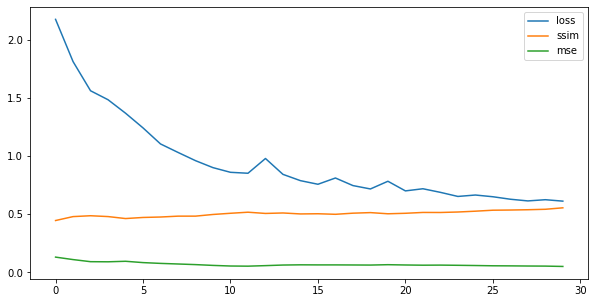

In [16]:
history_dict = pickle.load(open(history_save, "rb"))

plt.figure(figsize=(10,5))
plt.plot(history_dict["loss"],label="loss")
plt.plot(history_dict["ssim"],label="ssim")
plt.plot(history_dict["mean_squared_error"],label="mse")
plt.legend()
plt.savefig('../plots/srunet_perc_losses.pdf', bbox_inches='tight', format='pdf')

### Image evaluation

In [49]:
unet = tf.keras.models.load_model(os.path.join(save_dir, 'srunet_mse_64_to_128.h5'), compile=False)

In [45]:
test_gen = generator_vimeo(test_list, img_size, target_size, batch_size)

In [76]:
get_stats(unet, test_gen, test_list)

100%|████████████████████████████████████████████████████████████████████████████████| 783/783 [05:55<00:00,  2.20it/s]


MSE: 0.0021393818
PSNR: 27.923904
SSIM: 0.8996612


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


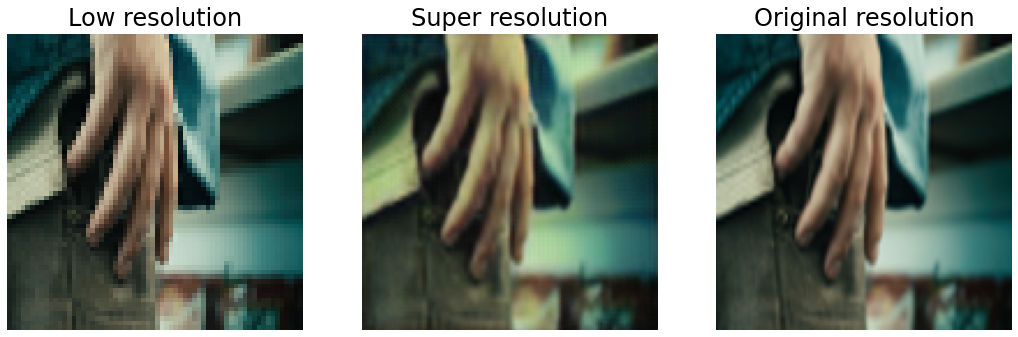

In [80]:
plot_comparison(unet, test_gen)

### Video evaluation

In [27]:
vid_name, ext = 'street', 'mp4'
reader = iio.get_reader('../data/' + vid_name + '.' + ext)
hr_frames = []
lr_frames = []
frames=[]
for i, im in enumerate(reader):
    hr_img = np.array(cv2.resize(im, (target_size, target_size), interpolation=cv2.INTER_CUBIC), dtype=np.uint8)
    hr_frames.append(np.array(hr_img, np.float32)/255.)
    
    lr_img = np.array(cv2.resize(im, (img_size, img_size), interpolation=cv2.INTER_CUBIC), dtype=np.uint8)
    lr_frames.append(np.array(lr_img, np.float32)/255.)

In [83]:
get_video_stats(unet, lr_frames, hr_frames)

304it [00:17, 16.95it/s]

MSE: 0.021373864
PSNR: 16.91301
SSIM: 0.51772875


In [50]:
sr_frames = []
for lr in lr_frames:
    sr = unet.predict(np.expand_dims(lr, axis=0))
    sr_frames.append(sr)
sr_frames = np.squeeze(np.array(sr_frames))

In [51]:
%%capture
iio.mimsave('../data/lr_srunet_mse_' + vid_name + '.gif', lr_frames, fps=24)
iio.mimsave('../data/sr_srunet_mse_' + vid_name + '.gif', sr_frames, fps=24)
iio.mimsave('../data/hr_srunet_mse_' + vid_name + '.gif', hr_frames, fps=24)

In [52]:
plot_video_comparison('../data/lr_srunet_mse_' + vid_name + '.gif', '../data/sr_srunet_mse_' + vid_name + '.gif', '../data/hr_srunet_mse_' + vid_name + '.gif')

,,


## SR-GAN

### Training

--------------- Epoch 1 ---------------


100%|██████████████████████████████████████████████████████████████████████████████| 1760/1760 [27:30<00:00,  1.07it/s]


discriminator_loss : 0.333161
gan_loss : [1.1314308643341064, 1.120931625366211, 10.49921989440918]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


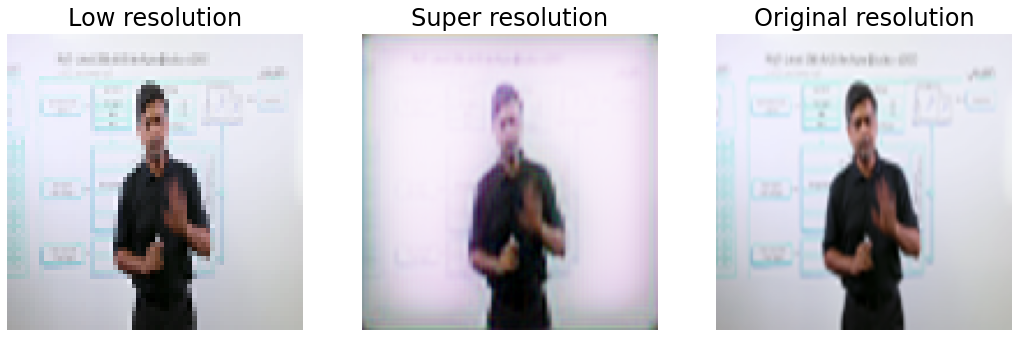

--------------- Epoch 2 ---------------


100%|██████████████████████████████████████████████████████████████████████████████| 1760/1760 [27:11<00:00,  1.08it/s]


discriminator_loss : 0.347863
gan_loss : [1.595754861831665, 1.5830451250076294, 12.709787368774414]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


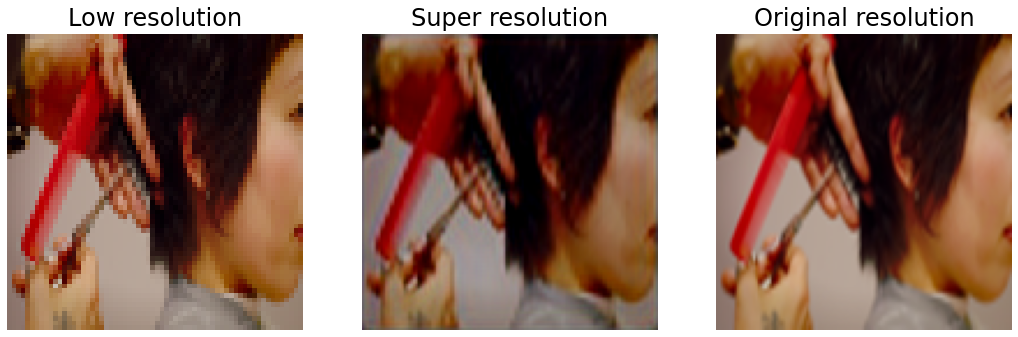

--------------- Epoch 3 ---------------


100%|██████████████████████████████████████████████████████████████████████████████| 1760/1760 [27:37<00:00,  1.06it/s]


discriminator_loss : 0.358507
gan_loss : [0.8538823127746582, 0.8482456207275391, 5.636694431304932]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


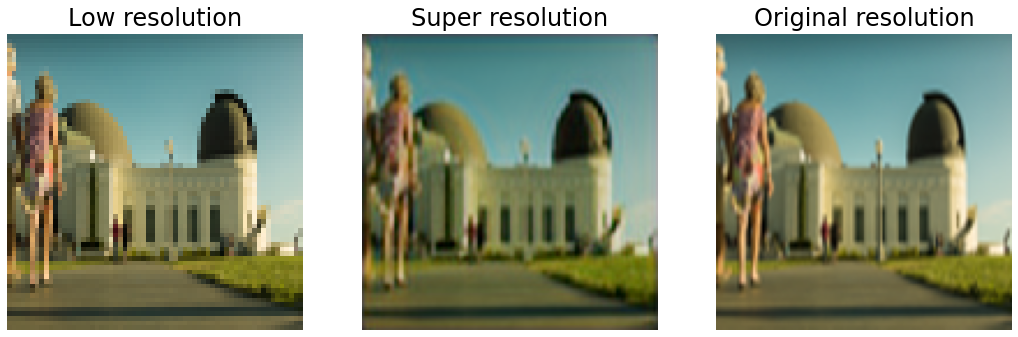

--------------- Epoch 4 ---------------


100%|██████████████████████████████████████████████████████████████████████████████| 1760/1760 [27:28<00:00,  1.07it/s]


discriminator_loss : 0.359682
gan_loss : [0.6385801434516907, 0.6372195482254028, 1.3606082201004028]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


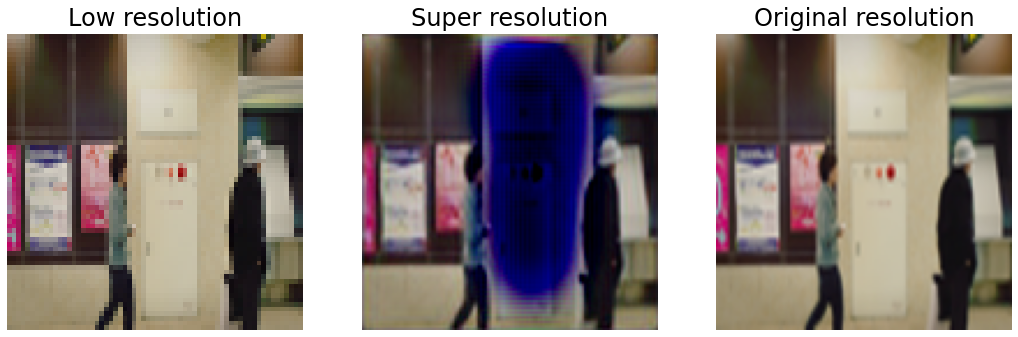

--------------- Epoch 5 ---------------


100%|██████████████████████████████████████████████████████████████████████████████| 1760/1760 [27:42<00:00,  1.06it/s]


discriminator_loss : 0.372850
gan_loss : [1.143673300743103, 1.1415234804153442, 2.1498210430145264]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


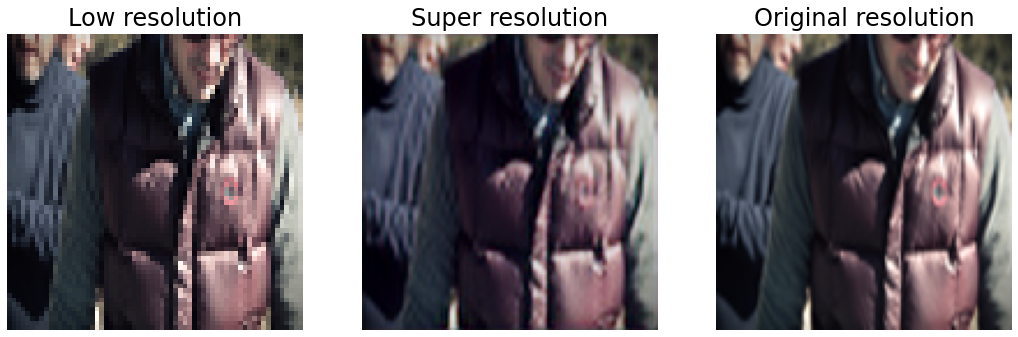

--------------- Epoch 6 ---------------


100%|██████████████████████████████████████████████████████████████████████████████| 1760/1760 [27:56<00:00,  1.05it/s]


discriminator_loss : 0.243594
gan_loss : [0.5108368992805481, 0.509655773639679, 1.1811254024505615]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


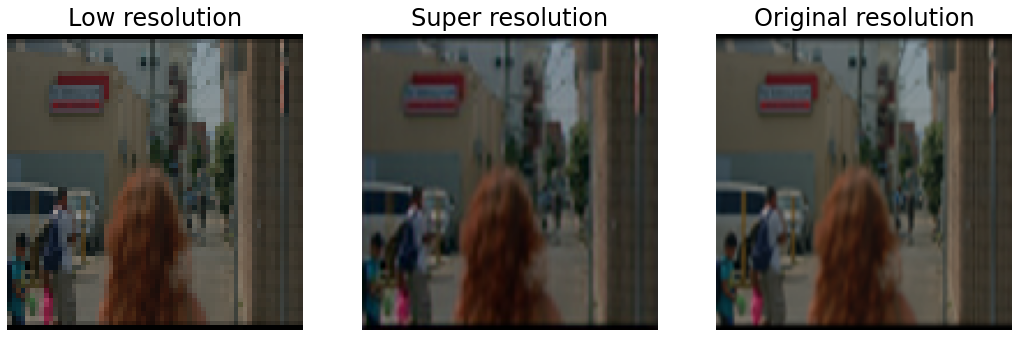

--------------- Epoch 7 ---------------


100%|██████████████████████████████████████████████████████████████████████████████| 1760/1760 [47:45<00:00,  1.63s/it]


discriminator_loss : 0.360911
gan_loss : [1.1219369173049927, 1.1209124326705933, 1.024507761001587]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


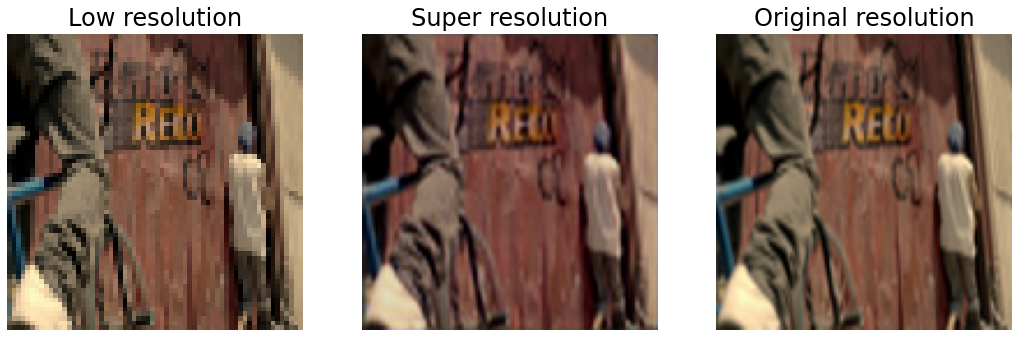

--------------- Epoch 8 ---------------


100%|██████████████████████████████████████████████████████████████████████████████| 1760/1760 [27:33<00:00,  1.06it/s]


discriminator_loss : 0.348960
gan_loss : [0.543554425239563, 0.5426563024520874, 0.8980929255485535]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


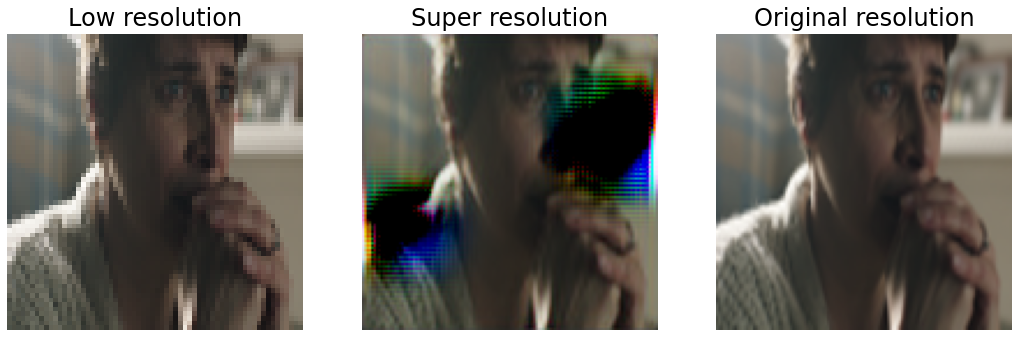

--------------- Epoch 9 ---------------


100%|██████████████████████████████████████████████████████████████████████████████| 1760/1760 [26:37<00:00,  1.10it/s]


discriminator_loss : 0.250302
gan_loss : [1.4407483339309692, 1.4395588636398315, 1.1894251108169556]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


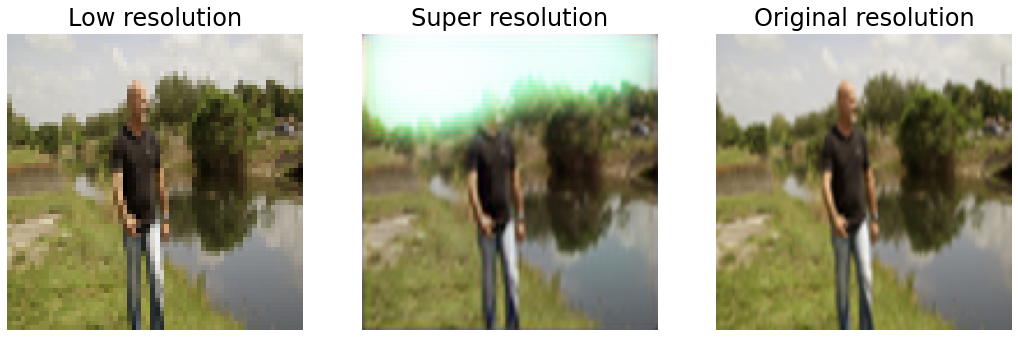

--------------- Epoch 10 ---------------


100%|██████████████████████████████████████████████████████████████████████████████| 1760/1760 [27:10<00:00,  1.08it/s]


discriminator_loss : 0.345165
gan_loss : [0.29244300723075867, 0.2913455665111542, 1.0974509716033936]


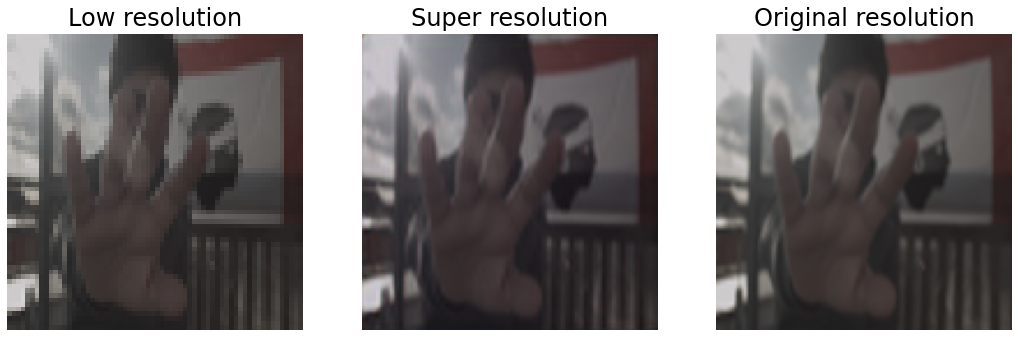

In [7]:
train_gan(img_size=img_size, target_size=target_size, epochs=10, batch_size=batch_size, batch_cnt=int(len(train_list) / batch_size),
          train_gen=generator_vimeo(train_list, img_size, target_size, 1), loss=perceptual_loss, save_dir=save_dir,
          desc='vimeo_perceptual')

### Evaluation

In [26]:
G = tf.keras.models.load_model(os.path.join(save_dir, 'srgan_perc_G_64_to_128__10.h5'), compile=False)
G.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 64)   15616       input_2[0][0]                    
__________________________________________________________________________________________________
p_re_lu (PReLU)                 (None, 64, 64, 64)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 64)   36928       p_re_lu[0][0]                    
_______________________________________________________________________________________

p_re_lu_15 (PReLU)              (None, 64, 64, 64)   64          batch_normalization_28[0][0]     
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 64, 64, 64)   36928       p_re_lu_15[0][0]                 
__________________________________________________________________________________________________
batch_normalization_29 (BatchNo (None, 64, 64, 64)   256         conv2d_30[0][0]                  
__________________________________________________________________________________________________
add_14 (Add)                    (None, 64, 64, 64)   0           add_13[0][0]                     
                                                                 batch_normalization_29[0][0]     
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 64, 64, 64)   36928       add_14[0][0]                     
__________

In [87]:
test_gen = generator_vimeo(test_list, img_size, target_size, batch_size)
get_stats(G, test_gen, test_list)

100%|████████████████████████████████████████████████████████████████████████████████| 783/783 [05:30<00:00,  2.37it/s]


MSE: 0.0050197174
PSNR: 29.96834
SSIM: 0.9163146


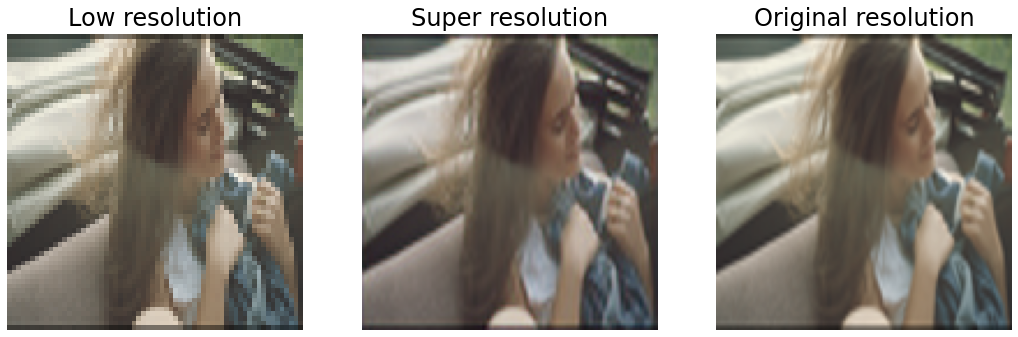

In [40]:
plot_comparison(G, test_gen)

In [28]:
get_video_stats(G, lr_frames, hr_frames)

304it [00:52,  5.83it/s]


MSE: 0.0650117
PSNR: 13.903452
SSIM: 0.43449697


In [29]:
sr_frames = []
for lr in lr_frames:
    hr = G.predict(np.expand_dims(lr, axis=0))
    sr_frames.append(hr)
sr_frames = np.squeeze(np.array(sr_frames))

In [36]:
%%capture
iio.mimsave('../data/lr_srgan_perc_' + vid_name + '.gif', lr_frames, fps=24)
iio.mimsave('../data/sr_srgan_perc_' + vid_name + '.gif', sr_frames, fps=24)
iio.mimsave('../data/hr_srgan_perc_' + vid_name + '.gif', hr_frames, fps=24)

In [35]:
plot_video_comparison('../data/lr_srgan_perc_' + vid_name + '.gif', '../data/sr_srgan_perc_' + vid_name + '.gif', '../data/hr_srgan_perc_' + vid_name + '.gif')

,,


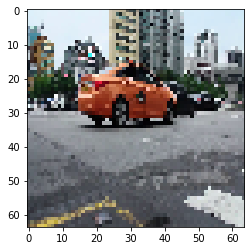

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


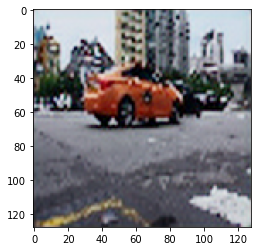

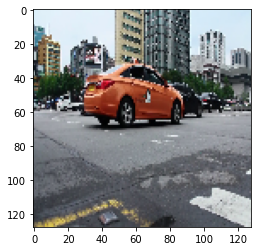

In [41]:
i = 10
plt.imshow(lr_frames[i])
plt.show()
plt.imshow(sr_frames[i])
plt.show()
plt.imshow(hr_frames[i])
plt.show()